## Toxic comments analysis

In [215]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import string
import scipy
import keras

### Read data

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
print('Train data:', train_df.shape)
print('Test data:', test_df.shape)
train_df.head()

Train data: (159571, 8)
Test data: (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
x_train = train_df['comment_text']
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

### Check the data

In [58]:
# Comment examples
x_train[:5].values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences f

In [6]:
# Classes statistics
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, 'Toxicity classes')

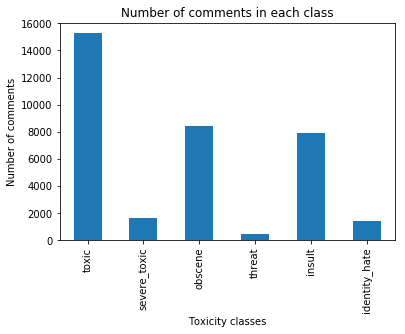

In [75]:
y_train.sum().plot.bar(title='Number of comments in each class')
plt.ylabel('Number of comments')
plt.xlabel('Toxicity classes')

In [228]:
# Check the lengths of the comments
lengths_list = pd.Series([len(x) for x in x_train])
lengths_list.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
dtype: float64

Text(0, 0.5, 'Number of comments')

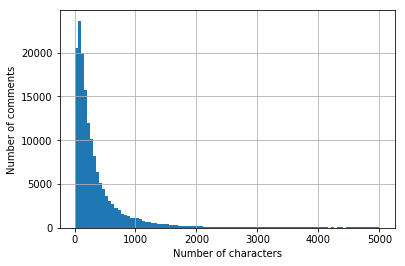

In [229]:
lengths_list.hist(bins=100)
plt.xlabel("Number of characters")
plt.ylabel("Number of comments")

Notes:
Need text cleaning, Imbalanced data, <10% are toxic


### Clean data

In [188]:
# Lowercase
x_train_clean = x_train.str.lower()

# Change empty space characters to spaces
x_train_clean = x_train_clean.str.replace(r'\s', ' ', regex=True)

# Remove non ASCII letters
x_train_clean = x_train_clean.str.replace(r"[^a-z ']+", '', regex=True)

# Normalize spaces (for readability)
x_train_clean = pd.Series([" ".join(x.split()) for x in x_train_clean])

x_train_clean[:5].values

array(["explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now",
       "d'aww he matches this background colour i'm seemingly stuck with thanks talk january utc",
       "hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info",
       "more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself plea

### Analyze words

In [197]:
# Bag of words
cv = CountVectorizer(stop_words='english', binary=True)
x_train_vec = cv.fit_transform(x_train_clean[:10])

In [198]:
word_freq = zip(cv.get_feature_names(), np.asarray(x_train_vec.sum(axis=0))[0])    
word_freq = sorted(word_freq, key=lambda x: -x[1])

In [199]:
# Top 20 most frequent words
word_freq[:20]

[('page', 4),
 ('talk', 4),
 ('article', 2),
 ('don', 2),
 ('edits', 2),
 ('formatting', 2),
 ('info', 2),
 ('just', 2),
 ('relevant', 2),
 ('reverted', 2),
 ('use', 2),
 ('vandalism', 2),
 ('accidents', 1),
 ('actual', 1),
 ('alignment', 1),
 ('animal', 1),
 ('appears', 1),
 ('articles', 1),
 ('articlewow', 1),
 ('aww', 1)]

### Vectorize text

In [230]:
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
x_train_vec = tfidf.fit_transform(x_train)

### Build model

In [231]:
# create model
model = Sequential()
model.add(Dense(8, input_dim=len(x_train_vec), activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'Sequential' is not defined